In [70]:
"""
In the first greenhousex we create inputs X, y from the entire dataframe which contains
CO2air and co2_dos columns. In this example we restrict the model to only
see CO2air as an input and only predict co2_dos (instead of co2_air).
"""

In [46]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib
import keras

from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv('cleangreenhousesnippet.csv')
df.index = df['%time']
df.drop('%time', axis=1, inplace=True)

In [48]:
# Ensure numeric
df = df.dropna()
df['CO2air'] = pd.to_numeric(df['CO2air'], errors='coerce')
df['co2_dos'] = pd.to_numeric(df['co2_dos'], errors='coerce')
df = df.dropna()

In [49]:
co2air = df['CO2air']
co2dos = df['co2_dos']

In [50]:
def df_to_X_y(df, window_size=10):
    df_as_np = df.to_numpy()  # shape: (num_samples, 2)
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        seq_co2air = df_as_np[i:i + window_size, 0]
        seq_co2air = seq_co2air.reshape(window_size, 1)
        X.append(seq_co2air)
        label_co2dos = df_as_np[i + window_size, 1]
        y.append(label_co2dos)

    return np.array(X), np.array(y).reshape(-1, 1)

In [51]:
X, y = df_to_X_y(df)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (47727, 10, 1) y shape: (47727, 1)


In [52]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:40000], y[35000:40000]
X_test, y_test = X[40000:], y[40000:]

In [58]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (35000, 10, 1) (35000, 1)
Val shapes: (5000, 10, 1) (5000, 1)
Test shapes: (7727, 10, 1) (7727, 1)


In [63]:
co2air_training_mean = np.mean(X_train)
co2air_training_std = np.std(X_train)

co2dos_training_mean = np.mean(y_train)
co2dos_training_std = np.std(y_train)

In [64]:
def preprocess_X(X):
    X = (X - co2air_training_mean) / co2air_training_std
    return X

def preprocess_y(y):
    y = (y - co2dos_training_mean) / co2dos_training_std
    return y

X_train = preprocess_X(X_train)
X_val = preprocess_X(X_val)
X_test = preprocess_X(X_test)

y_train = preprocess_y(y_train)
y_val = preprocess_y(y_val)
y_test = preprocess_y(y_test)

In [65]:
model5 = Sequential()
model5.add(InputLayer((10, 1)))  # 10 timesteps, 1 feature (CO2air only)
model5.add(LSTM(64))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(1, activation='linear'))  # Single output for co2_dos
model5.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
cp5 = ModelCheckpoint('model5/greenhousetest.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001),
               metrics=[RootMeanSquaredError()])

model5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, callbacks=[cp5])

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8540 - root_mean_squared_error: 0.9239 - val_loss: 3.3701 - val_root_mean_squared_error: 1.8358
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7962 - root_mean_squared_error: 0.8921 - val_loss: 3.3724 - val_root_mean_squared_error: 1.8364
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7840 - root_mean_squared_error: 0.8853 - val_loss: 3.3053 - val_root_mean_squared_error: 1.8180
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7871 - root_mean_squared_error: 0.8872 - val_loss: 3.3180 - val_root_mean_squared_error: 1.8215
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7535 - root_mean_squared_error: 0.8679 - val_loss: 3.3085 - val_root_mean_squared_error: 1.8189
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7141 - root_mean_squared_error: 0.8448 - val_loss: 3.1586 - val_root_mean_squared_error: 1.7772
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━

In [67]:
y_pred = model5.predict(X_test)

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [68]:
# y_pred_unscaled = y_pred * co2dos_training_std + co2dos_training_mean
# y_test_unscaled = y_test * co2dos_training_std + co2dos_training_mean

In [69]:
def plot_predictions(y_test, y_pred, start=0, end=200):
    end = min(end, len(y_test))
    y_test_sub = y_test[start:end]
    y_pred_sub = y_pred[start:end]
    x_axis = np.arange(start, end)

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, y_test_sub, label='Actual co2_dos', color='green')
    plt.plot(x_axis, y_pred_sub, label='Predicted co2_dos', color='orange', linestyle='--')
    plt.ylabel('co2_dos')
    plt.xlabel('Time Step')
    plt.legend()
    plt.title('Actual vs Predicted co2_dos')
    plt.show()

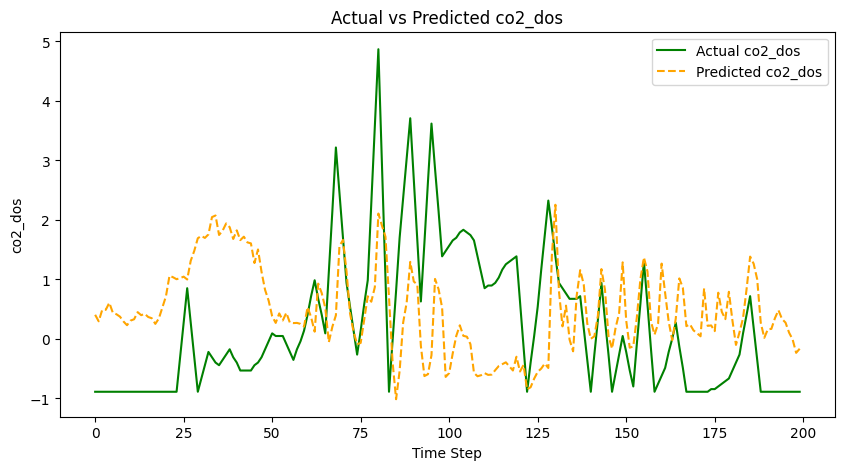

In [70]:
plot_predictions(y_test, y_pred)